In [1]:
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.util import *

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%reload_ext autotime

time: 0 ns (started: 2024-06-17 19:23:31 +09:00)


In [2]:
org = pd.read_csv('../data/electric_train.csv')

df = org.copy()

time: 8.61 s (started: 2024-06-17 19:23:31 +09:00)


In [3]:
df = clean_column_names(df)
df['날짜'] = pd.to_datetime(df['날짜'])

df

,격자넘버,날짜,시간,공동주택수,지점번호,계약전력합계,전력수요_합계,전력부하량_평균,기온,상대습도,풍속,강수량,체감온도,요일,주중_주말,전력기상지수
0,4821,2021-01-01 01:00:00,1,11,884,6950,751.32,68.606449,2.2,62.7,1.8,0.0,-1.0,4,0,99.56
1,4821,2021-01-01 02:00:00,2,11,884,6950,692.60,68.606449,2.3,63.1,2.1,0.0,-0.6,4,0,91.78
2,4821,2021-01-01 03:00:00,3,11,884,6950,597.48,68.606449,2.2,62.4,2.5,0.0,-1.3,4,0,79.17
3,4821,2021-01-01 04:00:00,4,11,884,6950,553.48,68.606449,1.7,63.5,1.7,0.0,-0.2,4,0,73.34
4,4821,2021-01-01 05:00:00,5,11,884,6950,526.24,68.606449,1.7,63.0,1.6,0.0,-0.8,4,0,69.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7593350,20947,2022-12-31 20:00:00,20,23,671,34200,6779.84,225.461986,2.7,46.3,3.1,0.0,-0.4,5,1,130.74
7593351,20947,2022-12-31 21:00:00,21,23,671,34200,6802.40,225.461986,2.6,46.8,3.1,0.0,-0.5,5,1,131.18
7593352,20947,2022-12-31 22:00:00,22,23,671,34200,6706.68,225.461986,2.4,47.4,2.1,0.0,0.2,5,1,129.33
7593353,20947,2022-12-31 23:00:00,23,23,671,34200,6355.88,225.461986,2.5,47.0,2.1,0.0,0.3,5,1,122.57


time: 3.64 s (started: 2024-06-17 19:23:40 +09:00)


# train set과 valid set

- train set: 2020년, 2021년
- valid set: 2022년

In [4]:
df.set_index('날짜').sort_index()

,격자넘버,시간,공동주택수,지점번호,계약전력합계,전력수요_합계,전력부하량_평균,기온,상대습도,풍속,강수량,체감온도,요일,주중_주말,전력기상지수
날짜,,,,,,,,,,,,,,,
2020-01-01 01:00:00,13615,1,39,140,63850,9732.96,250.490543,-8.5,74.5,0.9,0.0,-5.8,2,0,99.63
2020-01-01 01:00:00,18235,1,20,565,14750,2401.12,116.010234,-8.8,25.6,1.9,0.0,-4.6,2,0,103.49
2020-01-01 01:00:00,18234,1,32,565,71630,12139.16,363.252769,-8.8,25.6,1.9,0.0,-4.6,2,0,104.43
2020-01-01 01:00:00,18233,1,28,512,45840,6723.84,225.924357,-6.3,31.3,2.5,0.0,-7.8,2,0,106.29
2020-01-01 01:00:00,11272,1,44,941,76450,12949.24,287.250770,2.4,68.0,1.2,0.0,-5.3,2,0,102.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-01 00:00:00,12468,24,40,152,50075,8018.88,187.277655,7.1,60.2,4.5,0.0,-2.3,6,1,107.05
2023-01-01 00:00:00,16453,24,57,617,85000,13949.76,228.064905,-5.5,81.1,0.2,0.0,-2.9,6,1,107.31
2023-01-01 00:00:00,11418,24,36,253,63735,11472.28,296.369472,5.6,59.5,1.3,0.0,-1.6,6,1,107.53


time: 1 s (started: 2024-06-17 19:23:43 +09:00)


In [5]:
tmp = df.groupby(by='지점번호')['날짜'].agg(func=['max', 'min'])
tmp['기간'] = tmp['min'].dt.strftime('%Y-%m-%d') + ' ~ ' + tmp['max'].dt.strftime('%Y-%m-%d')

tmp

,max,min,기간
지점번호,,,
98,2023-01-01,2020-01-01 01:00:00,2020-01-01 ~ 2023-01-01
99,2021-01-01,2020-01-01 01:00:00,2020-01-01 ~ 2021-01-01
101,2023-01-01,2020-01-01 01:00:00,2020-01-01 ~ 2023-01-01
104,2023-01-01,2020-01-01 01:00:00,2020-01-01 ~ 2023-01-01
106,2022-01-01,2020-01-01 01:00:00,2020-01-01 ~ 2022-01-01
...,...,...,...
942,2023-01-01,2020-01-01 01:00:00,2020-01-01 ~ 2023-01-01
943,2023-01-01,2020-01-01 01:00:00,2020-01-01 ~ 2023-01-01
950,2023-01-01,2020-01-01 01:00:00,2020-01-01 ~ 2023-01-01


time: 172 ms (started: 2024-06-17 19:23:44 +09:00)


In [6]:
tmp['기간'].value_counts()

2020-01-01 ~ 2023-01-01    158
2020-01-01 ~ 2022-01-01     12
2020-01-01 ~ 2021-01-01      6
2021-01-01 ~ 2022-01-01      5
2021-01-01 ~ 2023-01-01      3
2022-01-01 ~ 2023-01-01      1
Name: 기간, dtype: int64

time: 0 ns (started: 2024-06-17 19:23:45 +09:00)


In [7]:
mask = tmp[tmp['기간'] == '2020-01-01 ~ 2023-01-01'].index

mask

Int64Index([ 98, 101, 104, 108, 112, 114, 119, 127, 129, 131,
            ...
            937, 938, 939, 940, 941, 942, 943, 950, 974, 991],
           dtype='int64', name='지점번호', length=158)

time: 0 ns (started: 2024-06-17 19:23:45 +09:00)


In [8]:
data = df[df['지점번호'].isin(mask)]
data = data.reset_index(drop=True)

time: 688 ms (started: 2024-06-17 19:23:45 +09:00)


In [9]:
data

,격자넘버,날짜,시간,공동주택수,지점번호,계약전력합계,전력수요_합계,전력부하량_평균,기온,상대습도,풍속,강수량,체감온도,요일,주중_주말,전력기상지수
0,5565,2020-01-01 01:00:00,1,58,184,42250,4468.72,79.776051,2.3,65.8,1.7,0.0,-0.3,2,0,96.58
1,5565,2020-01-01 02:00:00,2,58,184,42250,4101.00,79.776051,2.5,69.7,1.8,0.0,-0.2,2,0,88.63
2,5565,2020-01-01 03:00:00,3,58,184,42250,3724.60,79.776051,2.8,69.5,2.3,0.0,-0.2,2,0,80.50
3,5565,2020-01-01 04:00:00,4,58,184,42250,3484.40,79.776051,2.8,66.0,1.6,0.0,0.5,2,0,75.31
4,5565,2020-01-01 05:00:00,5,58,184,42250,3409.12,79.776051,3.0,66.1,1.6,0.0,0.5,2,0,73.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7198670,20947,2022-12-31 20:00:00,20,23,671,34200,6779.84,225.461986,2.7,46.3,3.1,0.0,-0.4,5,1,130.74
7198671,20947,2022-12-31 21:00:00,21,23,671,34200,6802.40,225.461986,2.6,46.8,3.1,0.0,-0.5,5,1,131.18
7198672,20947,2022-12-31 22:00:00,22,23,671,34200,6706.68,225.461986,2.4,47.4,2.1,0.0,0.2,5,1,129.33
7198673,20947,2022-12-31 23:00:00,23,23,671,34200,6355.88,225.461986,2.5,47.0,2.1,0.0,0.3,5,1,122.57


time: 31 ms (started: 2024-06-17 19:23:45 +09:00)


In [44]:
data['년'] = data['날짜'].dt.year
data['월'] = data['날짜'].dt.month
data['일'] = data['날짜'].dt.day
data['분기'] = data['날짜'].dt.quarter

train_data, valid_data = data[data['날짜'].dt.year < 2022], data[data['날짜'].dt.year >= 2022]

features = ['기온', '상대습도', '풍속', '강수량', '체감온도', '년', '월', '일', '시간', '요일', '분기', '지점번호']
X_train = train_data[features]
y_train = train_data['전력기상지수']
X_valid = valid_data[features]
y_valid = valid_data['전력기상지수']

numeric_features = ['기온', '상대습도', '풍속', '강수량', '체감온도', '년', '월', '일', '시간']
categorical_features = ['요일', '분기', '지점번호']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 칼럼 변환기 설정
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 변환기 적용
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)


print(X_train.shape)
print(X_valid.shape)

(4894519, 178)
(2304156, 178)
time: 13.4 s (started: 2024-06-17 19:43:05 +09:00)


In [11]:
# XGBRegressor 모델 학습
xgb_model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# 예측
y_pred = xgb_model.predict(X_valid)

# 성능 평가
mse = mean_squared_error(y_valid, y_pred)
r_score = get_rscore(y_valid, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R Score: {r_score}')

Mean Squared Error: 47.63541319728009
R Score: 0.9638557833000594
time: 32.9 s (started: 2024-06-17 19:23:55 +09:00)


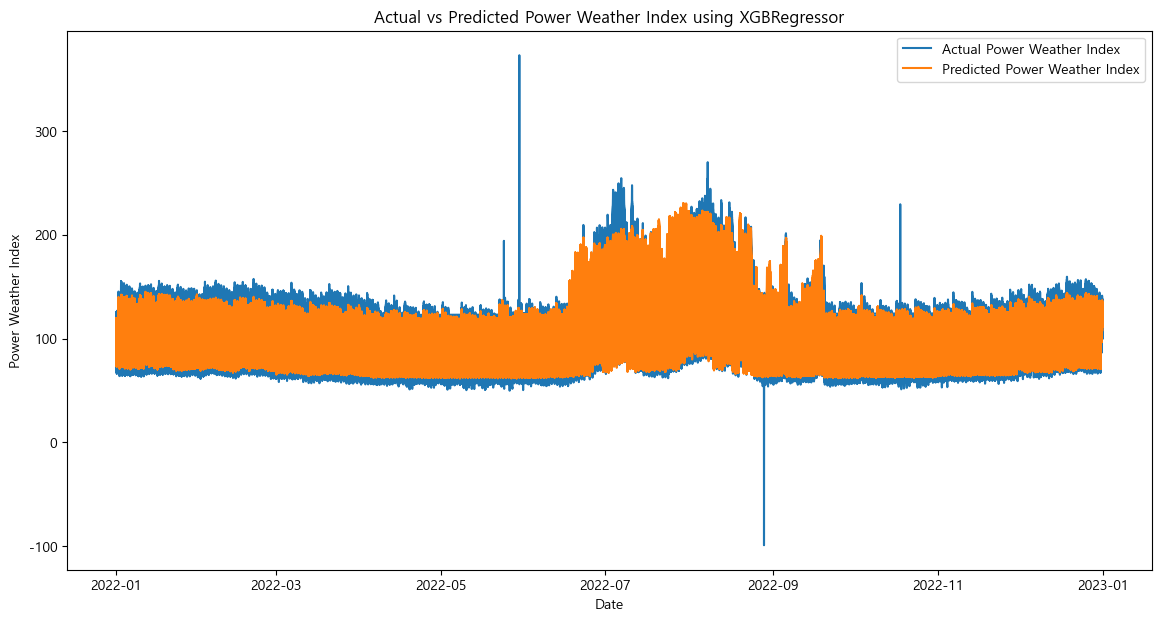

time: 9.06 s (started: 2024-06-17 19:24:28 +09:00)


In [12]:
# 실제 값과 예측 값 비교 시각화
plt.figure(figsize=(14, 7))
plt.plot(valid_data['날짜'], y_valid, label='Actual Power Weather Index')
plt.plot(valid_data['날짜'], y_pred, label='Predicted Power Weather Index')
plt.xlabel('Date')
plt.ylabel('Power Weather Index')
plt.title('Actual vs Predicted Power Weather Index using XGBRegressor')
plt.legend()
plt.show()

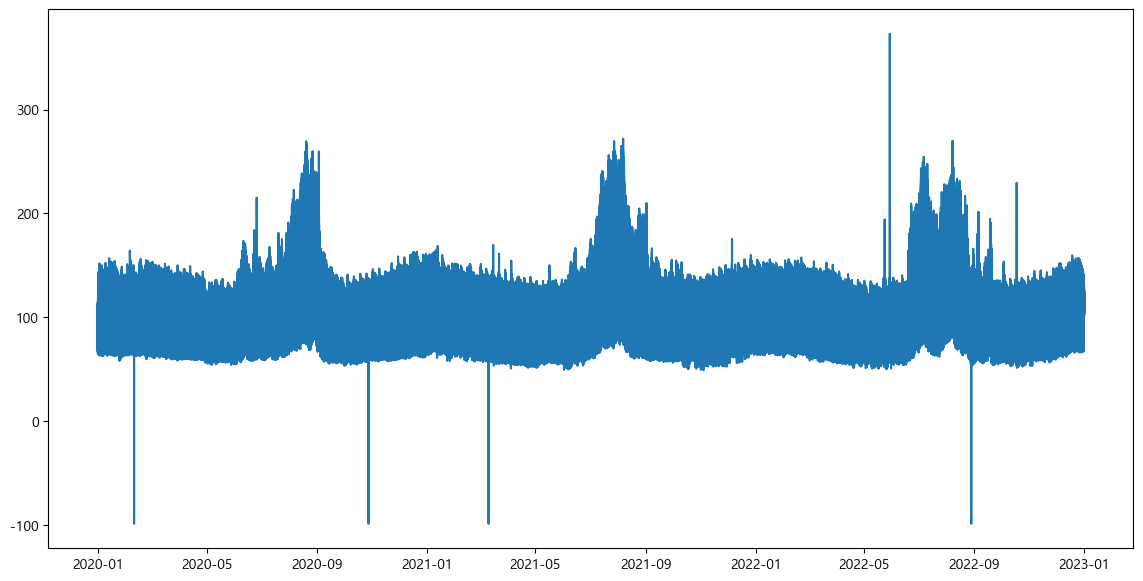

time: 29.9 s (started: 2024-06-17 19:24:37 +09:00)


In [13]:
plt.figure(figsize=(14, 7))
plt.plot(data['날짜'], data['전력기상지수'])

c:\ProgramData\Anaconda3\envs\wpy\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


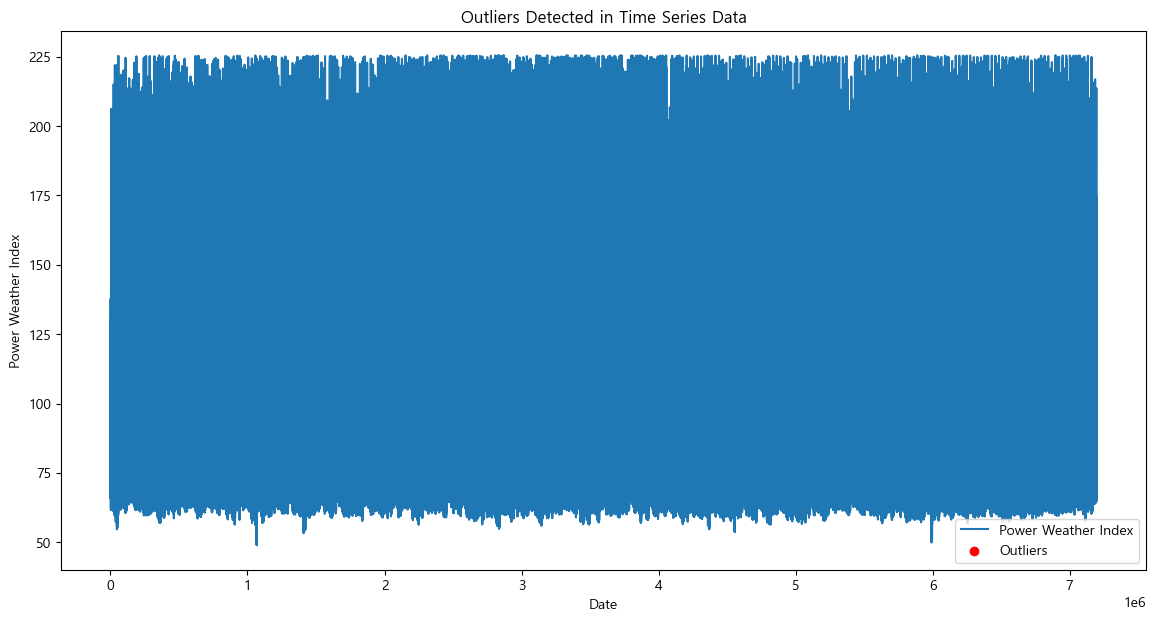

time: 14.9 s (started: 2024-06-17 19:43:31 +09:00)


In [45]:
from scipy import stats

ts_data = data['전력기상지수']

# z-score 계산
z_scores = np.abs(stats.zscore(ts_data))

# z-score가 7보다 큰 값을 이상치로 간주
outliers = ts_data[z_scores > 7]

# 이상치 표시
plt.figure(figsize=(14, 7))
plt.plot(ts_data, label='Power Weather Index')
plt.scatter(outliers.index, outliers, color='red', label='Outliers')
plt.xlabel('Date')
plt.ylabel('Power Weather Index')
plt.title('Outliers Detected in Time Series Data')
plt.legend()
plt.show()

In [46]:
outliers

Series([], Name: 전력기상지수, dtype: float64)

time: 16 ms (started: 2024-06-17 19:43:46 +09:00)


In [47]:
# 날짜를 datetime 형식으로 변환
data['날짜'] = pd.to_datetime(data['날짜'])
data.set_index('날짜', inplace=True)

outlier_base = 7

# 전력기상지수의 이상치 탐지 (예제로 Z-score 방법 사용)
z_scores = np.abs(stats.zscore(data['전력기상지수']))
outliers = data[z_scores > outlier_base]

# 지점번호별 월 평균 전력기상지수 계산
mean_by_station_and_month = data.groupby(['지점번호', '월'])['전력기상지수'].mean().reset_index()
mean_by_station_and_month.rename(columns={'전력기상지수': '월별_평균_전력기상지수'}, inplace=True)

# 원본 데이터와 월별 평균값을 결합 (merge)
data = data.reset_index()
data = pd.merge(data, mean_by_station_and_month, on=['지점번호', '월'], how='left')

# 이상치를 월별 평균값으로 대체
data['전력기상지수'] = np.where(z_scores > outlier_base, data['월별_평균_전력기상지수'], data['전력기상지수'])

# 필요에 따라 사용된 임시 열 제거
data.drop(columns=['월별_평균_전력기상지수'], inplace=True)

time: 6.08 s (started: 2024-06-17 19:43:46 +09:00)


c:\ProgramData\Anaconda3\envs\wpy\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


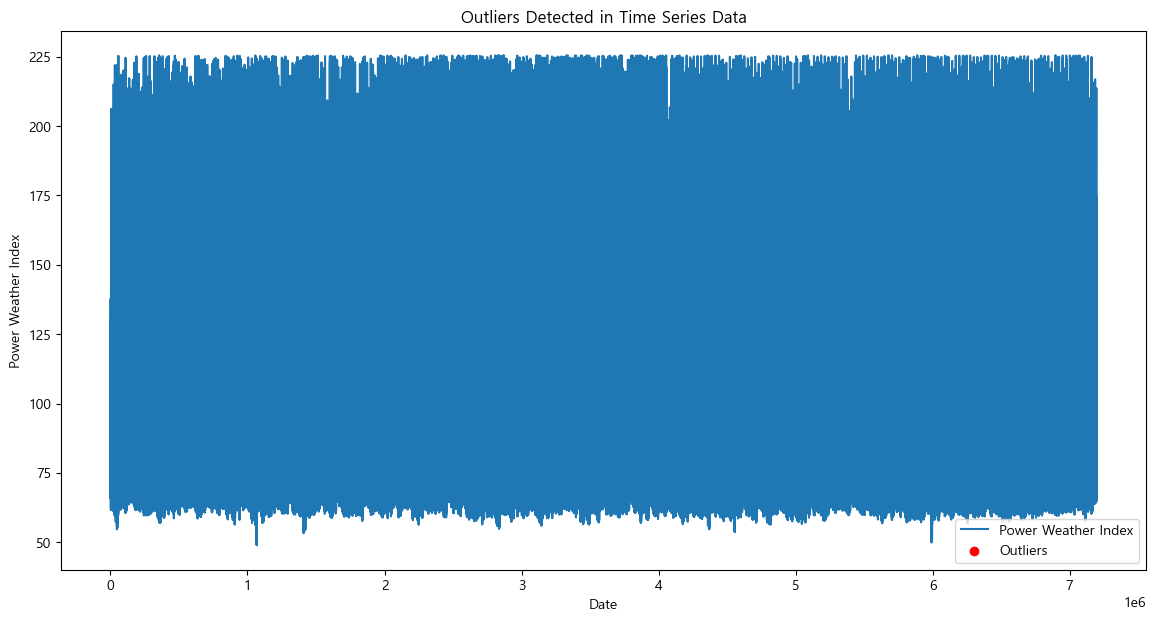

time: 15 s (started: 2024-06-17 19:43:52 +09:00)


In [48]:
from scipy import stats

ts_data = data['전력기상지수']

# z-score 계산
z_scores = np.abs(stats.zscore(ts_data))

# z-score가 7보다 큰 값을 이상치로 간주
outliers = ts_data[z_scores > 7]

# 이상치 표시
plt.figure(figsize=(14, 7))
plt.plot(ts_data, label='Power Weather Index')
plt.scatter(outliers.index, outliers, color='red', label='Outliers')
plt.xlabel('Date')
plt.ylabel('Power Weather Index')
plt.title('Outliers Detected in Time Series Data')
plt.legend()
plt.show()

In [49]:
data['년'] = data['날짜'].dt.year
data['월'] = data['날짜'].dt.month
data['일'] = data['날짜'].dt.day
data['분기'] = data['날짜'].dt.quarter

train_data, valid_data = data[data['날짜'].dt.year < 2022], data[data['날짜'].dt.year >= 2022]

features = ['기온', '상대습도', '풍속', '강수량', '체감온도', '년', '월', '일', '시간', '요일', '분기', '지점번호']
X_train = train_data[features]
y_train = train_data['전력기상지수']
X_valid = valid_data[features]
y_valid = valid_data['전력기상지수']

numeric_features = ['기온', '상대습도', '풍속', '강수량', '체감온도', '년', '월', '일', '시간']
categorical_features = ['요일', '분기', '지점번호']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 칼럼 변환기 설정
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 변환기 적용
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)


print(X_train.shape)
print(X_valid.shape)

(4894519, 178)
(2304156, 178)
time: 7.75 s (started: 2024-06-17 19:44:07 +09:00)


In [50]:
# XGBRegressor 모델 학습
xgb_model = XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# 예측
y_pred = xgb_model.predict(X_valid)

# 성능 평가
mse = mean_squared_error(y_valid, y_pred)
r_score = get_rscore(y_valid, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R Score: {r_score}')

Mean Squared Error: 45.17864163375177
R Score: 0.9649568183686451
time: 2min 15s (started: 2024-06-17 19:44:15 +09:00)


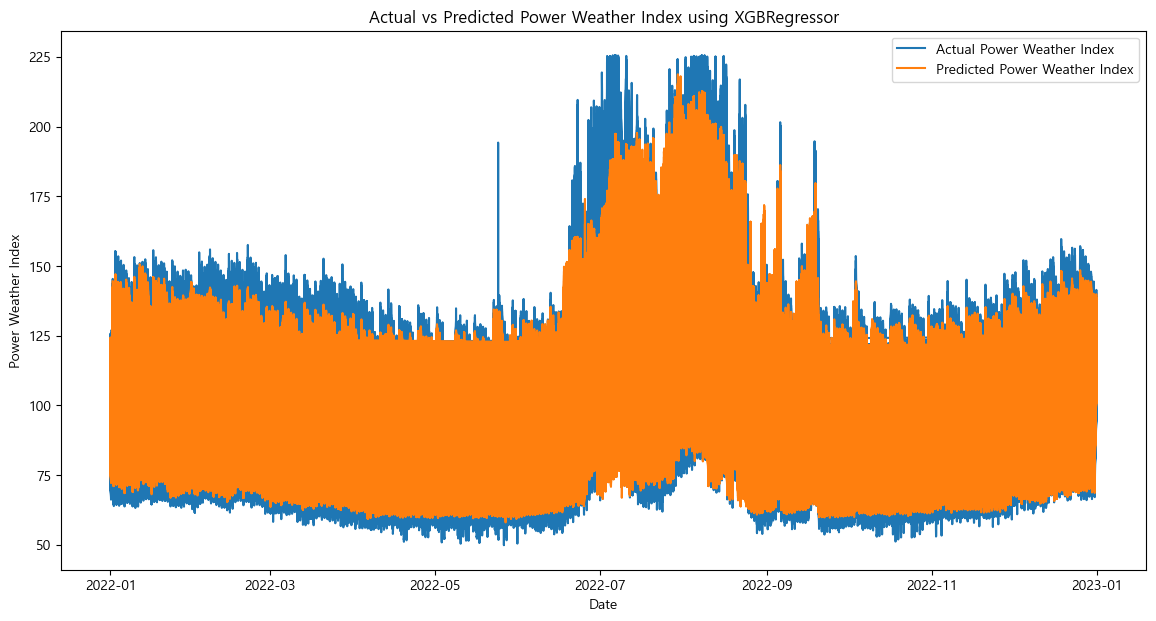

time: 21 s (started: 2024-06-17 19:46:57 +09:00)


In [51]:
# 실제 값과 예측 값 비교 시각화
plt.figure(figsize=(14, 7))
plt.plot(valid_data['날짜'], y_valid, label='Actual Power Weather Index')
plt.plot(valid_data['날짜'], y_pred, label='Predicted Power Weather Index')
plt.xlabel('Date')
plt.ylabel('Power Weather Index')
plt.title('Actual vs Predicted Power Weather Index using XGBRegressor')
plt.legend()
plt.show()

불쾌지수 추가

In [39]:
data['년'] = data['날짜'].dt.year
data['월'] = data['날짜'].dt.month
data['일'] = data['날짜'].dt.day
data['분기'] = data['날짜'].dt.quarter
data['불쾌지수'] = 0.81 * data['기온'] + 0.01 * data['상대습도'] * (0.99 * data['기온'] - 14.3) + 46.3

train_data, valid_data = data[data['날짜'].dt.year < 2022], data[data['날짜'].dt.year >= 2022]

features = ['풍속', '강수량', '체감온도', '년', '월', '일', '시간', '요일', '분기', '지점번호', '불쾌지수']
X_train = train_data[features]
y_train = train_data['전력기상지수']
X_valid = valid_data[features]
y_valid = valid_data['전력기상지수']

numeric_features = ['풍속', '강수량', '체감온도', '년', '월', '일', '시간', '불쾌지수']
categorical_features = ['요일', '분기', '지점번호']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 칼럼 변환기 설정
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 변환기 적용
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)


print(X_train.shape)
print(X_valid.shape)

(4894519, 177)
(2304156, 177)
time: 10.2 s (started: 2024-06-17 19:38:35 +09:00)


In [40]:
# XGBRegressor 모델 학습
xgb_model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# 예측
y_pred = xgb_model.predict(X_valid)

# 성능 평가
mse = mean_squared_error(y_valid, y_pred)
r_score = get_rscore(y_valid, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R Score: {r_score}')

Mean Squared Error: 48.5196355699584
R Score: 0.9625740898060031
time: 41.4 s (started: 2024-06-17 19:38:49 +09:00)


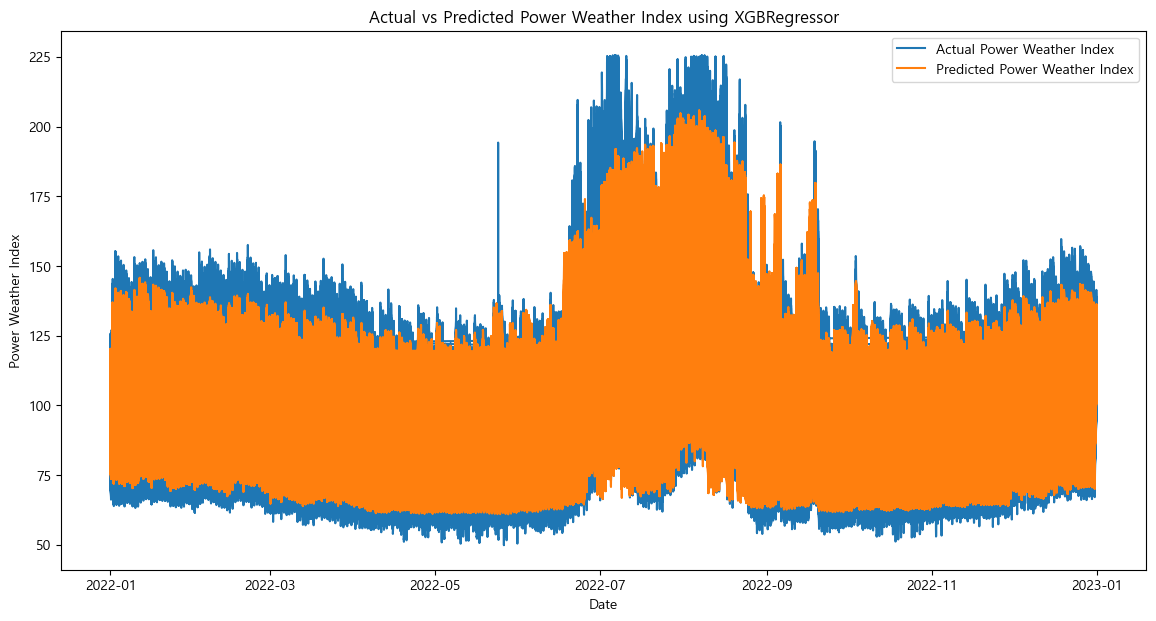

time: 19.5 s (started: 2024-06-17 19:39:30 +09:00)


In [41]:
# 실제 값과 예측 값 비교 시각화
plt.figure(figsize=(14, 7))
plt.plot(valid_data['날짜'], y_valid, label='Actual Power Weather Index')
plt.plot(valid_data['날짜'], y_pred, label='Predicted Power Weather Index')
plt.xlabel('Date')
plt.ylabel('Power Weather Index')
plt.title('Actual vs Predicted Power Weather Index using XGBRegressor')
plt.legend()
plt.show()

In [42]:
# XGBRegressor 모델 학습
xgb_model = XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# 예측
y_pred = xgb_model.predict(X_valid)

# 성능 평가
mse = mean_squared_error(y_valid, y_pred)
r_score = get_rscore(y_valid, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R Score: {r_score}')

Mean Squared Error: 46.66448397499143
R Score: 0.9638222267311125
time: 1min 59s (started: 2024-06-17 19:40:05 +09:00)


지금까지 실험 결과
- '기온'과 '상대습도'를 제거하고 '불쾌지수'를 추가했을 때가 더 성능이 안 좋음.
- outlier(z_score > 7) 제거한 것의 성능이 더 좋음.

앞으로 진행할 실험
- 평일, (공휴일, 주말) 추가
- 다른 모델 적용
- outlier 기준 변경(z_score -> by=['지점번호', '월']로 묶은 후 outlier 정의)